<a href="https://colab.research.google.com/github/platypusjerry/Airbnb-chicago_analysis/blob/main/airbnb_chicago_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analysis of Airbnb listings, Chicago**
Airbnb's publically available data of a large number of listings is a critical aspect for the company. This data is further cleaned and analyzed to provide various insights for the beneficiaries of the company. Various purposes include security decisions, business decisions, optimizing peer-to-peer compatibility, improving marketing and branding etc. Let us take a look into some of the visualizations that can be inferred from this dataset.

In [13]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'
import urllib.request
from urllib.request import urlopen
import json
from PIL import Image
import requests
from io import BytesIO

In [2]:
#reading the data-set
url = 'https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/listings_1.csv'
listing = pd.read_csv(url)
listing.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,65,2,182,2021-03-28,2.38,1,0
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85373,-87.69540,Entire home/apt,113,2,395,2020-07-14,2.67,1,180
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90166,-87.68021,Entire home/apt,65,2,394,2021-04-11,2.74,1,267
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91943,-87.63898,Entire home/apt,120,5,54,2021-01-15,0.63,11,1
4,10945,The Biddle House (#1),33004,At Home Inn,NaN,Lincoln Park,41.91196,-87.63981,Entire home/apt,175,4,22,2021-03-25,0.26,11,125


In [3]:
#shape of the data set we are working with
print(listing.shape)
print('Rows = {rows} in total and Columns = {columns} in total'.format(rows=listing.shape[0],columns=listing.shape[1]))

(6386, 16)
Rows = 6386 in total and Columns = 16 in total


### **CLEANING THE DATA**

In [4]:
listing.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                          169
neighbourhood_group               6386
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1218
reviews_per_month                 1218
calculated_host_listings_count       0
availability_365                     0
dtype: int64

We can see now that certain columns are void/are storing null values. We wish to clean the dataset further to make our analysis easier. 
The column "neighbourhood_group" is a void feature and columns "host_name", "last_review" and "reviews_per_month" have null values in places. Since there are no values for "number_of_reviews", it would be apt to replace the null values in "reviews_per_month" with zeroes. We can also drop the columns that will be irrelavant to us in any future exploration.

In [5]:
listing['reviews_per_month'].fillna(0,inplace = True)
listing['host_name'].fillna("N/A", inplace = True)
listing.drop(['neighbourhood_group', 'last_review'], axis=1, inplace = True)
listing.head(5)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,Hyde Park,41.78790,-87.58780,Private room,65,2,182,2.38,1,0
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,South Lawndale,41.85373,-87.69540,Entire home/apt,113,2,395,2.67,1,180
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,West Town,41.90166,-87.68021,Entire home/apt,65,2,394,2.74,1,267
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,Lincoln Park,41.91943,-87.63898,Entire home/apt,120,5,54,0.63,11,1
4,10945,The Biddle House (#1),33004,At Home Inn,Lincoln Park,41.91196,-87.63981,Entire home/apt,175,4,22,0.26,11,125


In [6]:
listing.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

### **A) TOP AREAS WITH HIGHEST NUMBER OF LISTINGS**
Since we aren't given neighbourhood groups in the dataset, let us take a look at the different unique neighbourhoods and listing concentrations around them.

In [7]:

print(listing.neighbourhood.unique())
listing.neighbourhood.unique().shape


['Hyde Park' 'South Lawndale' 'West Town' 'Lincoln Park' 'Near North Side'
 'Logan Square' 'Uptown' 'Near South Side' 'Lake View' 'North Center'
 'Albany Park' 'Pullman' 'West Ridge' 'Near West Side' 'Edgewater'
 'Bridgeport' 'Kenwood' 'Loop' 'Lincoln Square' 'Grand Boulevard'
 'Forest Glen' 'Austin' 'Lower West Side' 'East Garfield Park'
 'Rogers Park' 'North Lawndale' 'Oakland' 'Beverly' 'Chatham'
 'Mckinley Park' 'Woodlawn' 'Avondale' 'Humboldt Park' 'Norwood Park'
 'Portage Park' 'Washington Park' 'Morgan Park' 'Dunning' 'West Lawn'
 'South Shore' 'Irving Park' 'Armour Square' 'South Deering'
 'West Garfield Park' 'Hermosa' 'Douglas' 'Hegewisch' 'North Park'
 'West Elsdon' 'Jefferson Park' 'Ashburn' 'Greater Grand Crossing'
 'Belmont Cragin' 'Garfield Ridge' 'Brighton Park' 'West Pullman'
 'Archer Heights' 'Edison Park' 'Mount Greenwood' 'Englewood'
 'Chicago Lawn' 'South Chicago' 'Montclare' 'Clearing' 'Roseland'
 'Calumet Heights' 'New City' 'Fuller Park' 'Auburn Gresham'
 'West 

(77,)

Now let us look at the listings in each of these neighbourhoods-

In [8]:
print(listing.neighbourhood.value_counts())


Near North Side    749
West Town          685
Lake View          583
Logan Square       377
Loop               358
                  ... 
South Deering        2
Riverdale            2
Burnside             1
Avalon Park          1
Gage Park            1
Name: neighbourhood, Length: 77, dtype: int64


showing a count for the top 10 areas with the most number of listings

Near North Side    749
West Town          685
Lake View          583
Logan Square       377
Loop               358
Near West Side     353
Lincoln Park       289
Near South Side    181
Lower West Side    173
Uptown             170
Name: neighbourhood, dtype: int64


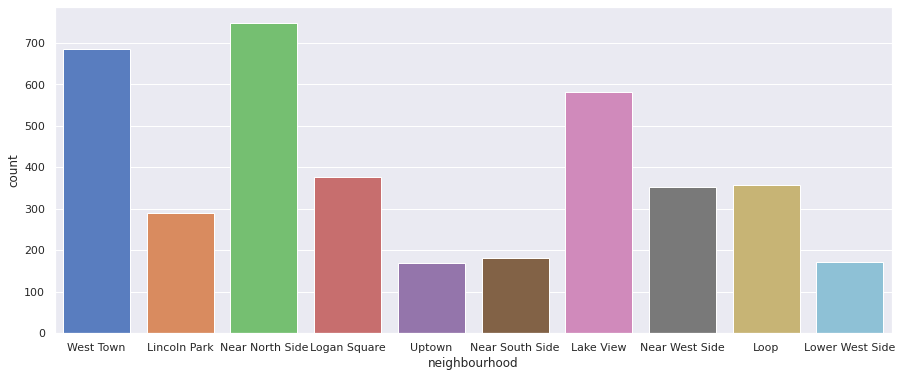

In [9]:
np = listing.neighbourhood.value_counts()
np_1 = np.head(10)
print(np_1)
df_1 = listing.loc[listing['neighbourhood'].isin(np_1.index.tolist())]

sns.set_theme(style="darkgrid")
f,plt_1 = plt.subplots(figsize=(15,6))
plt_2 = sns.countplot(x = "neighbourhood", data = df_1, palette= "muted")
plt.show()

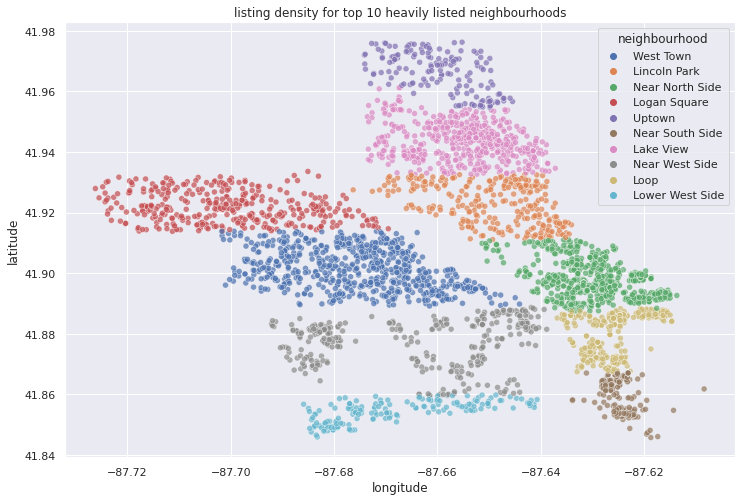

In [10]:
np_1.to_frame()
np_1 = pd.DataFrame(np_1, columns=['neighbourhood'])
np_1.reset_index(level=0, inplace=True)
np_1.rename(columns={'index':'neighbourhood', 'neighbourhood':'listings'})

np_2 = listing.loc[listing['neighbourhood'].isin(['Near North Side','West Town', 'Lake View', 'Logan Square', 'Loop', 'Near West Side', 'Lincoln Park', 'Near South Side', 'Lower West Side', 'Uptown'])]
np_3 = np_2[['neighbourhood','latitude', 'longitude']]

fig = plt.gcf()
fig.set_size_inches(12, 8)
g = sns.scatterplot(data=np_3, y="latitude", x="longitude", hue="neighbourhood", alpha=0.7)
g.set_title('listing density for top 10 heavily listed neighbourhoods');

### **B) THEMATIC PLOT OF REGION BY ROOM TYPES**

In [ ]:
with urlopen('https://raw.githubusercontent.com/platypusjerry/Airbnb-chicago_analysis/main/neighbourhoods.geojson') as response:
  map_chic = json.load(response)

print(listing["neighbourhood"][0])
print(map_chic['features'][0]["properties"])

fig = px.choropleth_mapbox(listing, geojson=map_chic, color="room_type",
                           locations="neighbourhood", featureidkey="properties.neighbourhood",
                           center={"lat": 45.5517, "lon": -73.7073},
                           mapbox_style="carto-positron", zoom=9)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

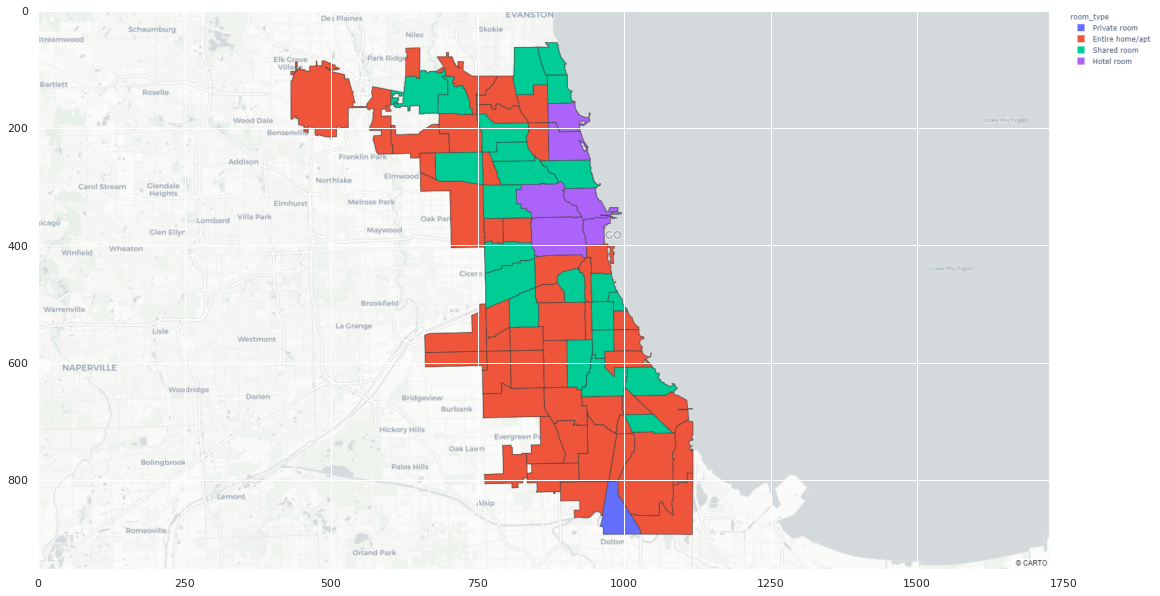

In [ ]:
imgurl = 'https://github.com/platypusjerry/Airbnb-chicago_analysis/blob/main/newplot.png?raw=true'
response = requests.get(imgurl)
img = Image.open(BytesIO(response.content))
plt.figure(figsize = (20, 18))
plt.imshow(np.asarray(img))

### **C) TOP 10 HOSTS BY THE TOTAL NUMBER OF LISTINGS** 

Top 10 host IDs 
 107434423    233
3965428       79
47172572      68
12243051      53
170785489     51
9094538       43
359234447     36
63313003      34
49626033      31
100782278     29
Name: host_id, dtype: int64


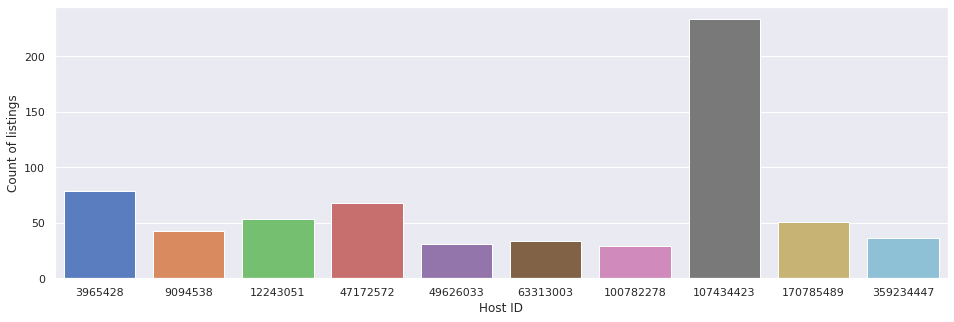

Top 10 host names 
 Blueground    233
N/A           169
Rob            88
Zencity        68
Joe            65
John           58
Nicole         58
Michael        54
Sonder         53
Dmd            51
Name: host_name, dtype: int64


In [ ]:
df_2 = listing.host_id.value_counts()
arr_2 = df_2.head(10)
print('Top 10 host IDs \n', arr_2)

sns.set_theme(style="darkgrid")
f,plt_2 = plt.subplots(figsize=(16,5))
plt_2 = sns.barplot(x = arr_2.index, y= arr_2.values, palette="muted")
plt_2.set_ylabel('Count of listings')
plt_2.set_xlabel('Host ID')
plt.show()

#Names of the top 10 hosts
df_3 = listing.host_name.value_counts().head(10)
print('Top 10 host names \n',df_3)


### **D) PRICES AND NEIGHBOURHOODS- ANALYSIS**

In [ ]:
df_5 = listing.groupby('neighbourhood')['price'].mean()

In [ ]:
df_5.to_frame()
df_5.sort_values(inplace=True, ascending=False)
print(df_5.head(5))

neighbourhood
West Englewood     533.333333
Loop               269.980447
Lake View          233.615780
Lincoln Park       215.536332
Near North Side    213.783712
Name: price, dtype: float64


We can see which of the neighbourhood listings have the highest average price per day. Let us visualize the distribution for the five costliest listed neighbourhoods.

In [ ]:
n_group = pd.DataFrame(df_5, columns = ['price'])
n_group.reset_index(level=0, inplace=True)
print(n_group.head(6))

     neighbourhood       price
0   West Englewood  533.333333
1             Loop  269.980447
2        Lake View  233.615780
3     Lincoln Park  215.536332
4  Near North Side  213.783712
5         Burnside  200.000000


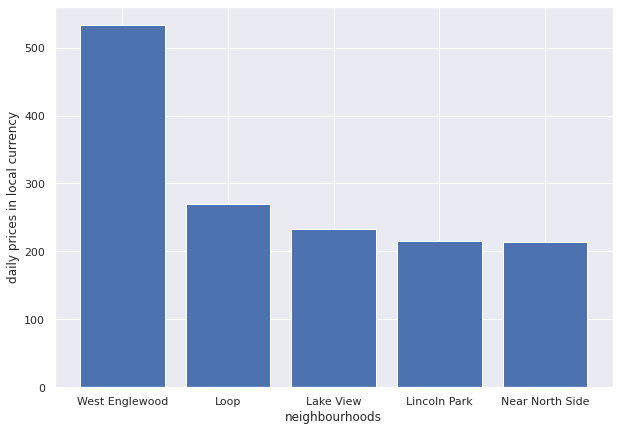

In [ ]:
X = n_group['neighbourhood'].head(5)
Y = n_group['price'].head(5)
 
fig = plt.figure(figsize =(10, 7))
 
plt.bar(X, Y)
plt.xlabel('neighbourhoods')
plt.ylabel('daily prices in local currency')
 
plt.show()

Price heatmap across entire region for all listings

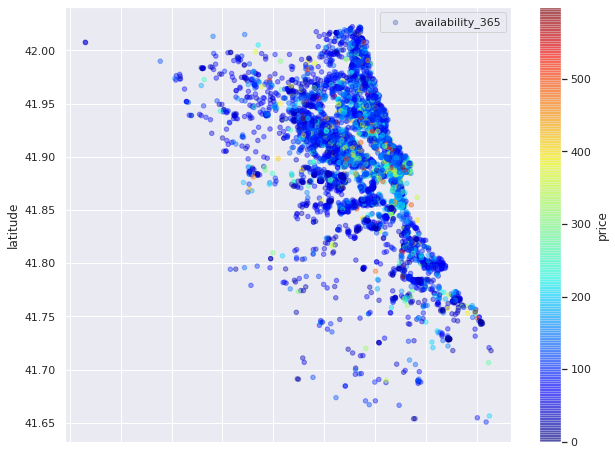

In [ ]:
mp1 = listing[listing.price < 600]
plt_4 = mp1.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))
plt_4.legend()